In [ ]:
import csv
import sys
import os
import glob
import gzip
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

sns.set()
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)

# DA sys data

In [2]:
WMT19_ROOT = '/iesl/canvas/jwei/mtmetrics/wmt19-metrics-task/'
da_sys = pd.read_csv(os.path.join(WMT19_ROOT, 'manual-evaluation/DA-syslevel.csv'), delimiter=' ', header=0)
da_sys.columns = ['lp', 'DA', 'system']

In [3]:
print(len(da_sys))
da_sys.head()

225


,lp,DA,system
0,en-cs,0.402,CUNI-DocTransformer-T2T.6751
1,en-cs,0.401,CUNI-Transformer-T2T-2018.6457
2,en-cs,0.388,CUNI-Transformer-T2T-2019.6851
3,en-cs,0.223,CUNI-DocTransformer-Marian.6922
4,en-cs,0.206,uedin.6667


# DA seg data

In [4]:
da_seg = pd.read_csv(os.path.join(WMT19_ROOT, 'manual-evaluation/RR-seglevel.csv'), delimiter=' ', header=0)
da_seg.columns = ['lp', 'testset', 'segid', 'better', 'worse']

In [5]:
print(len(da_seg))
da_seg.head()

571791


,lp,testset,segid,better,worse
0,de-en,newstest2019,1718,uedin.6749,online-A.0
1,de-en,newstest2019,1718,online-X.0,online-A.0
2,de-en,newstest2019,1718,online-X.0,online-G.0
3,de-en,newstest2019,1718,online-X.0,NEU.6801
4,de-en,newstest2019,1718,JHU.6809,online-A.0


# seg-level data

### seg-level submissions

In [6]:
seg_scores = pd.DataFrame.from_dict({'lp':[], 'testset':[], 'docid':[], 'system':[], 'segid':[]})

for i, submission in enumerate(glob.glob(os.path.join(WMT19_ROOT, 'final-metric-scores/submissions-corrected/*.seg.score.gz'))):
    submission_scores = pd.read_csv(gzip.open(submission, 'rt'), header=None, delimiter='\t')
    name = submission_scores[0].unique()[0]
    print('Metric: %s' % name)
    
    submission_scores = submission_scores.drop([0, 7, 8], axis=1)
    submission_scores.columns = ['lp', 'testset', 'docid', 'system', 'segid', name]

    seg_scores = pd.merge(seg_scores, submission_scores, on=['lp', 'testset', 'docid', 'system', 'segid'], how='outer')

Metric: ibm1-morpheme
Metric: LEPORa
Metric: UNI+
Metric: USFD-TL
Metric: YiSi-2_srl
Metric: YiSi-1
Metric: UNI
Metric: ibm1-pos4gram
Metric: YiSi-0
Metric: YiSi-2
Metric: CharacTER
Metric: LASIM
Metric: PReP
Metric: YiSi-1_srl
Metric: USFD
Metric: BEER
Metric: BERTr
Metric: Meteor++_2.0(syntax+copy)
Metric: ESIM
Metric: EED
Metric: LP
Metric: Meteor++_2.0(syntax)


### seg-level baselines

In [7]:
seg_baseline_scores = pd.DataFrame.from_dict({'lp':[], 'testset':[], 'docid':[], 'system':[], 'segid':[]})

for i, baseline in enumerate(glob.glob(os.path.join(WMT19_ROOT, 'baselines/sentBLEU.seg.score.gz'))):
    submission_scores = pd.read_csv(gzip.open(baseline, 'rt'), header=None, delimiter='\t')
    name = submission_scores[0].unique()[0]
    
    print('Metric: %s' % name)
    submission_scores = submission_scores.drop([0], axis=1)
    # when baselines have docids
    submission_scores.columns = ['lp', 'testset', 'docid', 'system', 'segid', name]

    seg_baseline_scores = pd.merge(seg_baseline_scores, submission_scores, on=['lp', 'testset', 'system', 'docid', 'segid'], how='outer')

In [8]:
#seg_all_scores = pd.merge(seg_scores, seg_baseline_scores, on=['lp', 'testset', 'system', 'docid', 'segid'], how='outer')
seg_all_scores = seg_scores
assert(len(seg_all_scores[seg_all_scores.docid.isna()]) == 0)

In [9]:
# remove testsuites
seg_all_scores_nots = seg_all_scores[~seg_all_scores.docid.str.contains('testsuite')]
print('# of instances: %d, without testsuites: %d' % (len(seg_all_scores), len(seg_all_scores_nots)))

# remove "NO REFERENCE AVAILABLE"
# TODO

# of instances: 1275953, without testsuites: 391536


# sys-level data

### sys-level submissions that are averages

In [13]:
sys_scores = seg_all_scores_nots.groupby(['lp','system']).agg(lambda g: g.mean(skipna=False))
sys_scores.head()

BEER  BERTr  CharacTER       EED      ESIM  \
lp    system                                                                    
cs-de NEU_KingSoft.6783        0.521164    NaN  -0.579090 -0.429170  0.308052   
      NICT.6948                0.532291    NaN  -0.562077 -0.415512  0.369723   
      Unsupervised.cs-de.6979  0.491136    NaN  -0.620657 -0.465025  0.164337   
      online-A.0               0.543414    NaN  -0.556908 -0.407853  0.400460   
      online-B.0               0.550559    NaN  -0.563379 -0.406231  0.435272   

                               LASIM    LEPORa  LP  Meteor++_2.0(syntax)  \
lp    system                                                               
cs-de NEU_KingSoft.6783          NaN  0.555167 NaN                   NaN   
      NICT.6948                  NaN  0.574953 NaN                   NaN   
      Unsupervised.cs-de.6979    NaN  0.516998 NaN                   NaN   
      online-A.0                 NaN  0.574255 NaN                   NaN   
      online-B.0                 NaN  0.579523 NaN                   NaN   

                               Meteor++_2.0(syntax+copy)  PReP  UNI  UNI+  \
lp    system                                                                
cs-de NEU_KingSoft.6783                              NaN   NaN  NaN   NaN   
      NICT.6948                                      NaN   NaN  NaN   NaN   
      Unsupervised.cs-de.6979                        NaN   NaN  NaN   NaN   
      online-A.0                                     NaN   NaN  NaN   NaN   
      online-B.0                                     NaN   NaN  NaN   NaN   

                               USFD  USFD-TL    YiSi-0    YiSi-1  YiSi-1_srl  \
lp    system                                                                   
cs-de NEU_KingSoft.6783         NaN      NaN  0.578039  0.822059    0.798195   
      NICT.6948                 NaN      NaN  0.588336  0.825959    0.803194   
      Unsupervised.cs-de.6979   NaN      NaN  0.544226  0.803474    0.779544   
      online-A.0                NaN      NaN  0.605472  0.834409    0.810392   
      online-B.0                NaN      NaN  0.612783  0.839165    0.815379   

                                 YiSi-2  YiSi-2_srl  ibm1-morpheme  \
lp    system                                                         
cs-de NEU_KingSoft.6783        0.781374         NaN -265922.511524   
      NICT.6948                0.776106         NaN -254404.898076   
      Unsupervised.cs-de.6979  0.770832         NaN -298972.252442   
      online-A.0               0.771953         NaN -348546.194517   
      online-B.0               0.767865         NaN -327013.444073   

                               ibm1-pos4gram        segid  
lp    system                                               
cs-de NEU_KingSoft.6783                  NaN  2630.664997  
      NICT.6948                          NaN  2630.664997  
      Unsupervised.cs-de.6979            NaN  2630.664997  
      online-A.0                         NaN  2630.664997  
      online-B.0                         NaN  2630.664997

### sys-level submissions

In [33]:
# only leporb is a custom sys level
submission_scores = pd.read_csv(gzip.open(os.path.join(WMT19_ROOT, 'final-metric-scores/submissions-corrected/LEPORb.sys.score.gz'), 'rt'), header=None, delimiter='\t')
name = submission_scores[0].unique()[0]
print('Metric: %s' % name)

sys_submission_scores = submission_scores.drop([0, 5, 6], axis=1)
sys_submission_scores.columns = ['lp', 'testset', 'system', 'LEPORb']

Metric: hLEPORb_baseline


In [34]:
# only leporb is a custom sys level
submission_scores = pd.read_csv(gzip.open(os.path.join(WMT19_ROOT, 'final-metric-scores/submissions-corrected/WMDO.sys.score.gz'), 'rt'), header=None, delimiter='\t')
name = submission_scores[0].unique()[0]
print('Metric: %s' % name)

submission_scores = submission_scores.drop([0, 5, 6], axis=1)
submission_scores.columns = ['lp', 'testset', 'system', 'WMDO']
sys_submission_scores = pd.merge(sys_submission_scores, submission_scores, on=['lp', 'testset', 'system'], how='outer')

Metric: WMDO


### sys-level baselines

In [35]:
sys_baseline_scores = pd.DataFrame.from_dict({'lp':[], 'testset':[], 'system':[]})

for i, baseline in enumerate(glob.glob(os.path.join(WMT19_ROOT, 'baselines/*.sys.score.gz'))):
    submission_scores = pd.read_csv(gzip.open(baseline, 'rt'), header=None, delimiter='\t')
    
    for name in submission_scores[0].unique():
        print('Metric: %s' % name)
        name_submission_scores = submission_scores[submission_scores[0] == name].drop([0], axis=1)
        name_submission_scores.columns = ['lp', 'testset', 'system', name]
        
        #drop hybrids from qingsongs files
        name_submission_scores = name_submission_scores[~name_submission_scores.system.str.contains('hybrid')]
        
        sys_baseline_scores = pd.merge(sys_baseline_scores, name_submission_scores, on=['lp', 'testset', 'system'], how='outer')

Metric: NIST
Metric: BLEU
Metric: chrF
Metric: sacreBLEU-BLEU
Metric: TER
Metric: CDER
Metric: sacreBLEU-chrF
Metric: WER
Metric: chrF+
Metric: PER


In [36]:
sys_baseline_scores.head()

,lp,testset,system,NIST,BLEU,chrF,sacreBLEU-BLEU,TER,CDER,sacreBLEU-chrF,WER,chrF+,PER
0,cs-de,newstest2019,NEU_KingSoft.6783,4.8260,0.1376,48.2633,0.1867,0.3086,0.3804,49.0992,0.2819,48.4078,0.4816
1,cs-de,newstest2019,NICT.6948,5.0419,0.1495,49.7396,0.2008,0.3186,0.3950,50.9079,0.2920,50.0038,0.4919
2,cs-de,newstest2019,online-A.0,5.5975,0.1785,50.7529,0.2248,0.3507,0.4106,51.8920,0.3237,50.9467,0.5333
3,cs-de,newstest2019,online-B.0,6.0876,0.1990,51.0832,0.2348,0.3823,0.4215,51.8939,0.3570,51.2481,0.5298
4,cs-de,newstest2019,online-G.0,5.8784,0.1925,50.9056,0.2380,0.3618,0.4082,51.3502,0.3362,50.9688,0.5226


In [37]:
sys_all_scores = pd.merge(sys_scores, sys_baseline_scores, on=['lp', 'system'])
sys_all_scores = pd.merge(sys_all_scores, sys_submission_scores, on=['lp', 'system', 'testset'], how='outer')
sys_all_scores.head()

,lp,system,BEER,BERTr,CharacTER,EED,ESIM,LASIM,LEPORa,LP,Meteor++_2.0(syntax),Meteor++_2.0(syntax+copy),PReP,UNI,UNI+,USFD,USFD-TL,YiSi-0,YiSi-1,YiSi-1_srl,YiSi-2,YiSi-2_srl,ibm1-morpheme,ibm1-pos4gram,segid,testset,NIST,BLEU,chrF,sacreBLEU-BLEU,TER,CDER,sacreBLEU-chrF,WER,chrF+,PER,LEPORb,WMDO
0,cs-de,NEU_KingSoft.6783,0.521164,NaN,-0.579090,-0.429170,0.308052,NaN,0.555167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.578039,0.822059,0.798195,0.781374,NaN,-265922.511524,NaN,2630.664997,newstest2019,4.8260,0.1376,48.2633,0.1867,0.3086,0.3804,49.0992,0.2819,48.4078,0.4816,0.482544,NaN
1,cs-de,NICT.6948,0.532291,NaN,-0.562077,-0.415512,0.369723,NaN,0.574953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.588336,0.825959,0.803194,0.776106,NaN,-254404.898076,NaN,2630.664997,newstest2019,5.0419,0.1495,49.7396,0.2008,0.3186,0.3950,50.9079,0.2920,50.0038,0.4919,0.517669,NaN
2,cs-de,Unsupervised.cs-de.6979,0.491136,NaN,-0.620657,-0.465025,0.164337,NaN,0.516998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.544226,0.803474,0.779544,0.770832,NaN,-298972.252442,NaN,2630.664997,newstest2019,4.2279,0.1097,43.9169,0.1594,0.2754,0.3479,44.7687,0.2531,44.1180,0.4514,0.452313,NaN
3,cs-de,online-A.0,0.543414,NaN,-0.556908,-0.407853,0.400460,NaN,0.574255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.605472,0.834409,0.810392,0.771953,NaN,-348546.194517,NaN,2630.664997,newstest2019,5.5975,0.1785,50.7529,0.2248,0.3507,0.4106,51.8920,0.3237,50.9467,0.5333,0.521943,NaN
4,cs-de,online-B.0,0.550559,NaN,-0.563379,-0.406231,0.435272,NaN,0.579523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.612783,0.839165,0.815379,0.767865,NaN,-327013.444073,NaN,2630.664997,newstest2019,6.0876,0.1990,51.0832,0.2348,0.3823,0.4215,51.8939,0.3570,51.2481,0.5298,0.529952,NaN


# checks

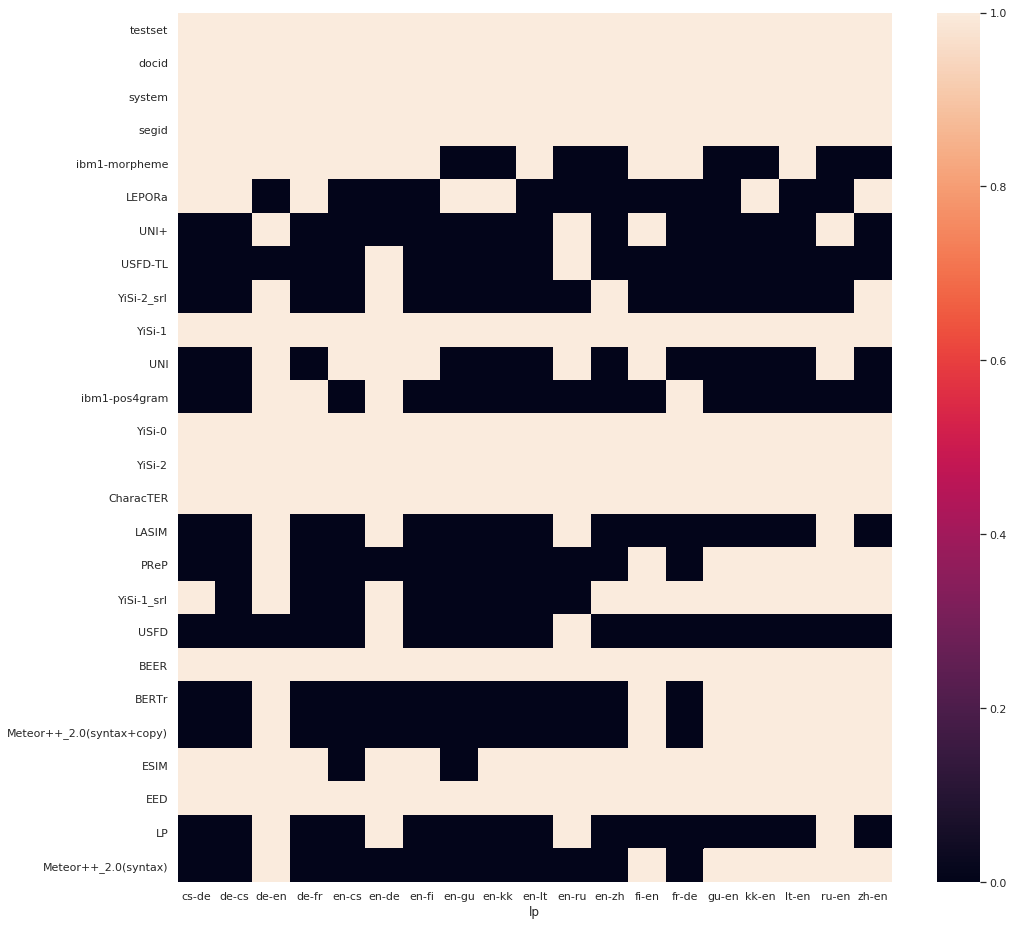

In [38]:
# segment level checks
counts = seg_all_scores_nots.groupby('lp').count().T
counts = (counts / counts.max())
sns.set()
plt.figure(figsize=(16,16))
sns.heatmap(counts)

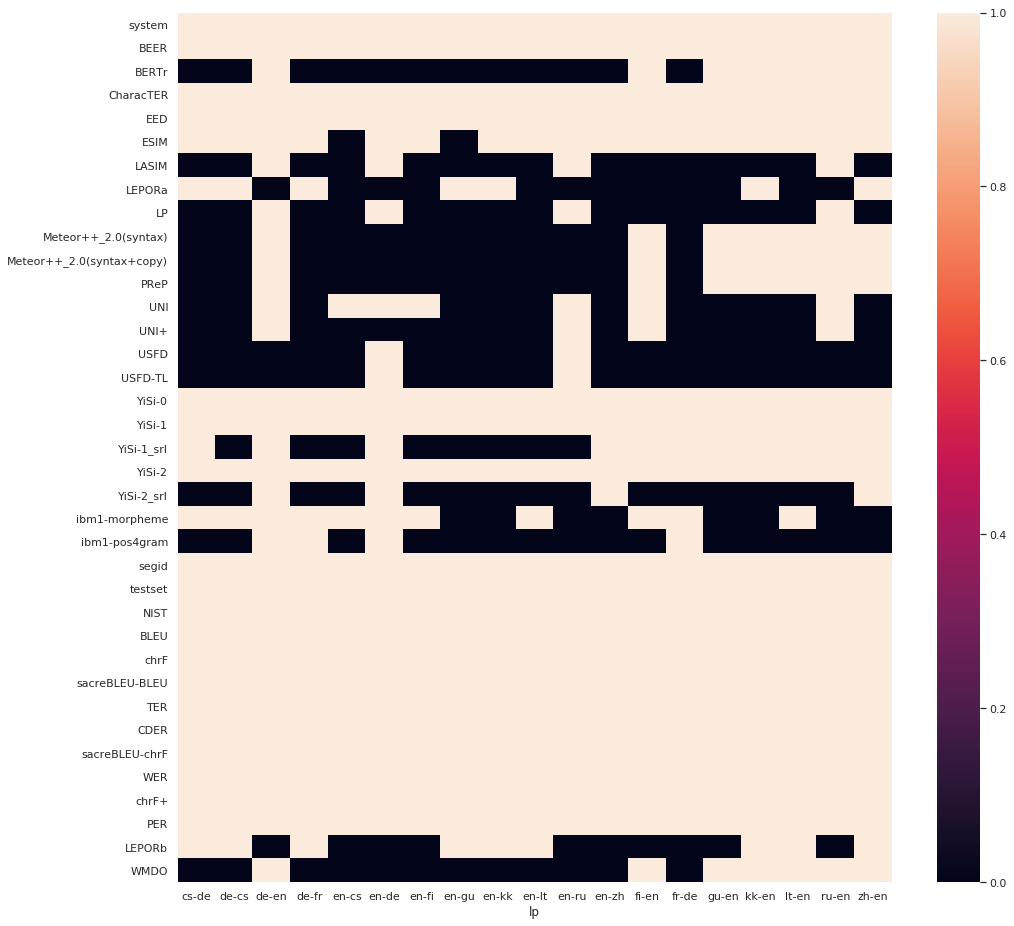

In [39]:
# segment level checks
counts = sys_all_scores.groupby('lp').count().T
counts = (counts / counts.max())
sns.set()
plt.figure(figsize=(16,16))
sns.heatmap(counts)

# sys-level correlations

In [42]:
df = pd.merge(da_sys, sys_all_scores, on=['lp', 'system'], how='outer')

# partial results if da_sys has na
df = df[df.DA.notna()]
df

,lp,DA,system,BEER,BERTr,CharacTER,EED,ESIM,LASIM,LEPORa,LP,Meteor++_2.0(syntax),Meteor++_2.0(syntax+copy),PReP,UNI,UNI+,USFD,USFD-TL,YiSi-0,YiSi-1,YiSi-1_srl,YiSi-2,YiSi-2_srl,ibm1-morpheme,ibm1-pos4gram,segid,testset,NIST,BLEU,chrF,sacreBLEU-BLEU,TER,CDER,sacreBLEU-chrF,WER,chrF+,PER,LEPORb,WMDO
0,en-cs,0.402,CUNI-DocTransformer-T2T.6751,0.587546,NaN,-0.473012,-0.358870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.451509,NaN,NaN,NaN,0.647281,0.865066,NaN,0.764996,NaN,-538834.399788,NaN,5622.518277,newstest2019,5.1045,0.1904,57.5673,0.3103,0.4697,0.5042,56.1449,0.4427,57.7576,0.6061,NaN,NaN
1,en-cs,0.401,CUNI-Transformer-T2T-2018.6457,0.586932,NaN,-0.472164,-0.360134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.451607,NaN,NaN,NaN,0.647019,0.865321,NaN,0.763242,NaN,-527818.114977,NaN,5622.518277,newstest2019,5.2036,0.1968,57.4147,0.3093,0.4714,0.5042,56.1830,0.4452,57.5857,0.6037,NaN,NaN
2,en-cs,0.388,CUNI-Transformer-T2T-2019.6851,0.579734,NaN,-0.484397,-0.368192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.449209,NaN,NaN,NaN,0.639329,0.860957,NaN,0.763402,NaN,-536831.475870,NaN,5622.518277,newstest2019,5.0849,0.1892,56.3307,0.3042,0.4647,0.4977,55.3537,0.4386,56.5415,0.5971,NaN,NaN
3,en-cs,0.223,CUNI-DocTransformer-Marian.6922,0.574024,NaN,-0.490662,-0.372733,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.449402,NaN,NaN,NaN,0.633046,0.858328,NaN,0.761952,NaN,-522309.622032,NaN,5622.518277,newstest2019,4.8610,0.1769,55.8463,0.2917,0.4513,0.4877,54.5194,0.4243,55.9912,0.5878,NaN,NaN
4,en-cs,0.206,uedin.6667,0.576676,NaN,-0.486119,-0.370773,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.450413,NaN,NaN,NaN,0.635241,0.861178,NaN,0.763326,NaN,-542339.781808,NaN,5622.518277,newstest2019,5.1417,0.1916,56.0571,0.2900,0.4589,0.4895,55.0079,0.4323,56.1944,0.5877,NaN,NaN
5,en-cs,-0.156,online-Y.0,0.549563,NaN,-0.525134,-0.397881,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.449820,NaN,NaN,NaN,0.610651,0.848201,NaN,0.770330,NaN,-500276.152644,NaN,5622.518277,newstest2019,4.9027,0.1766,52.5263,0.2419,0.4111,0.4420,51.7642,0.3849,52.5183,0.5474,NaN,NaN
6,en-cs,-0.195,TartuNLP-c.6633,0.541926,NaN,-0.529825,-0.404621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.455128,NaN,NaN,NaN,0.601906,0.845137,NaN,0.765198,NaN,-487757.221393,NaN,5622.518277,newstest2019,4.5523,0.1581,51.2223,0.2398,0.3988,0.4393,50.9746,0.3736,51.3854,0.5430,NaN,NaN
7,en-cs,-0.300,online-G.0,0.536465,NaN,-0.544898,-0.413207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.453648,NaN,NaN,NaN,0.596673,0.839007,NaN,0.771972,NaN,-492263.672062,NaN,5622.518277,newstest2019,4.4931,0.1543,49.9492,0.2094,0.3681,0.4006,48.7988,0.3451,49.9858,0.5032,NaN,NaN
8,en-cs,-0.336,online-B.0,0.538573,NaN,-0.545561,-0.412536,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.454067,NaN,NaN,NaN,0.596506,0.841805,NaN,0.768849,NaN,-497771.752224,NaN,5622.518277,newstest2019,4.8643,0.1775,50.5443,0.2250,0.3883,0.4232,50.0956,0.3631,50.6535,0.5268,NaN,NaN
9,en-cs,-0.594,online-A.0,0.513498,NaN,-0.577613,-0.437866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.446666,NaN,NaN,NaN,0.569549,0.827444,NaN,0.756182,NaN,-502779.258109,NaN,5622.518277,newstest2019,4.3666,0.1466,47.0265,0.1883,0.3447,0.3824,46.6877,0.3223,47.1066,0.4865,NaN,NaN


In [43]:
df[df.lp.str.endswith('en')].groupby('lp').corr().round(3)[::36].T

lp,de-en,fi-en,gu-en,kk-en,lt-en,ru-en,zh-en
,DA,DA,DA,DA,DA,DA,DA
DA,1.000,1.000,1.000,1.000,1.000,1.000,1.000
BEER,0.906,0.993,0.952,0.986,0.947,0.915,0.942
BERTr,0.926,0.984,0.938,0.990,0.948,0.971,0.974
CharacTER,0.898,0.990,0.922,0.953,0.955,0.923,0.943
EED,0.903,0.994,0.976,0.980,0.929,0.950,0.949
ESIM,0.941,0.971,0.885,0.986,0.989,0.968,0.988
LASIM,0.247,NaN,NaN,NaN,NaN,-0.310,NaN
LEPORa,NaN,NaN,NaN,0.975,NaN,NaN,0.947
LP,-0.474,NaN,NaN,NaN,NaN,-0.488,NaN


In [44]:
df[df.lp.str.startswith('en')].groupby('lp').corr().round(3)[::36].T.dropna(how='all')

lp,en-cs,en-de,en-fi,en-gu,en-kk,en-lt,en-ru,en-zh
,DA,DA,DA,DA,DA,DA,DA,DA
DA,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
BEER,0.990,0.983,0.989,0.829,0.971,0.982,0.977,0.803
CharacTER,0.994,0.986,0.968,0.910,0.936,0.954,0.985,0.862
EED,0.993,0.985,0.987,0.897,0.979,0.975,0.967,0.856
ESIM,NaN,0.991,0.957,NaN,0.980,0.989,0.989,0.931
LASIM,NaN,0.871,NaN,NaN,NaN,NaN,-0.823,NaN
LEPORa,NaN,NaN,NaN,0.841,0.968,NaN,NaN,NaN
LP,NaN,-0.569,NaN,NaN,NaN,NaN,-0.661,NaN
UNI,0.028,0.841,0.907,NaN,NaN,NaN,0.919,NaN


### william test parameters

In [ ]:
metric_da_corrs = {}
metric_metric_corrs = {}
ns = {}

#TODO need to decide on the signs for some of
#the metrics, LP, ibm1-morpheme...

for lp in df['lp'].unique():
    print(lp)
    
    corr_matrix = df[df.lp == lp].drop(['segid'], axis=1).corr().round(3)
    
    metrics = []
    metric_da_corr = []
    for row in corr_matrix['DA'][1:].dropna().sort_values().iteritems():
        metric_da_corr.append((row[0], row[1]))
        metrics.append(row[0])
        print(row)
    metric_da_corrs[lp] = metric_da_corr
    
    metric_metric_corr = []
    for i, i_metric in enumerate(metrics):
        row = []
        for j, j_metric in enumerate(metrics):
            if  i >= j:
                continue
            else:
                row.append(corr_matrix[i_metric][j_metric])
        metric_metric_corr.append(row)
    metric_metric_corrs[lp] = metric_metric_corr
        
    print('\n'.join('\t'.join(str(i) for i in row) for row in metric_metric_corr).strip())
    
    n = len(df[df.lp == lp])
    print(n)
    print()

# Top-n curves

In [45]:
import matplotlib.font_manager
matplotlib.font_manager.findfont('DejaVu Serif')

'/home/jwei/miniconda3/envs/mt_metrics/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif.ttf'

In [46]:
# lps = ['de-en', 'en-de', 'zh-en', 'en-zh', 'en-cs']
lps = df.lp.unique()
lp_top_n = {}
for lp in lps:
    df_lp = df[df.lp == lp]
    df_lp['rank'] = df_lp['DA'].rank(ascending=False)
    corrs = []
    for i in range(len(df_lp), 2, -1):
        df_lp_subset = df_lp[df_lp['rank'] <= i].dropna(axis=1)
        df_lp_subset = df_lp_subset.drop(['lp', 'system', 'segid', 'testset', 'rank'], axis=1)
        corr = df_lp_subset.corr().round(3)['DA']
        corr['rank'] = i
        corrs.append(corr)

    top_n = pd.concat(corrs, axis=1).T
    lp_top_n[lp] = top_n
lp_top_n['de-en']

/home/jwei/miniconda3/envs/mt_metrics/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,DA,BEER,BERTr,CharacTER,EED,ESIM,LASIM,LP,Meteor++_2.0(syntax),Meteor++_2.0(syntax+copy),PReP,UNI,UNI+,YiSi-0,YiSi-1,YiSi-1_srl,YiSi-2,YiSi-2_srl,ibm1-morpheme,ibm1-pos4gram,NIST,BLEU,chrF,sacreBLEU-BLEU,TER,CDER,sacreBLEU-chrF,WER,chrF+,PER,WMDO,rank
DA,1.0,0.906,0.926,0.898,0.903,0.941,0.247,-0.474,0.887,0.896,0.575,0.846,0.850,0.902,0.949,0.950,0.796,0.804,-0.345,-0.339,0.813,0.849,0.917,0.813,0.874,0.890,0.910,0.863,0.916,0.883,0.872,16.0
DA,1.0,0.852,0.897,0.852,0.853,0.896,0.334,-0.279,0.844,0.850,0.452,0.809,0.805,0.847,0.914,0.916,0.612,0.630,-0.223,-0.137,0.705,0.770,0.862,0.794,0.812,0.827,0.852,0.803,0.860,0.808,0.857,15.0
DA,1.0,0.760,0.809,0.764,0.761,0.810,-0.034,-0.094,0.746,0.750,0.341,0.669,0.656,0.754,0.843,0.847,0.303,0.343,-0.071,-0.262,0.500,0.621,0.778,0.684,0.713,0.757,0.770,0.706,0.780,0.715,0.748,14.0
DA,1.0,0.701,0.758,0.705,0.729,0.720,-0.232,-0.100,0.700,0.702,0.226,0.588,0.576,0.715,0.778,0.782,0.266,0.279,0.199,-0.244,0.483,0.625,0.739,0.669,0.607,0.692,0.737,0.595,0.739,0.667,0.728,13.0
DA,1.0,0.629,0.725,0.634,0.668,0.656,-0.220,-0.222,0.628,0.632,0.052,0.577,0.560,0.651,0.749,0.754,0.179,0.199,0.207,-0.172,0.436,0.571,0.681,0.590,0.524,0.618,0.677,0.510,0.681,0.587,0.664,12.0
DA,1.0,0.691,0.720,0.694,0.719,0.655,-0.115,-0.074,0.682,0.685,-0.073,0.463,0.448,0.714,0.794,0.796,0.423,0.436,0.213,0.132,0.590,0.676,0.734,0.642,0.615,0.683,0.736,0.604,0.728,0.667,0.654,11.0
DA,1.0,0.548,0.569,0.531,0.566,0.470,-0.101,0.131,0.515,0.522,-0.280,0.164,0.161,0.567,0.697,0.702,0.236,0.239,-0.073,-0.105,0.468,0.549,0.591,0.487,0.511,0.535,0.595,0.506,0.582,0.506,0.473,10.0
DA,1.0,0.685,0.720,0.706,0.735,0.520,0.146,-0.068,0.677,0.685,-0.332,0.211,0.220,0.708,0.848,0.857,0.503,0.531,0.412,-0.010,0.571,0.642,0.724,0.579,0.634,0.682,0.722,0.643,0.724,0.635,0.590,9.0
DA,1.0,0.575,0.617,0.609,0.644,0.307,0.053,0.341,0.552,0.562,0.419,-0.310,-0.251,0.615,0.801,0.814,0.468,0.489,0.266,-0.326,0.495,0.550,0.639,0.451,0.523,0.565,0.640,0.532,0.634,0.539,0.440,8.0
DA,1.0,0.534,0.737,0.600,0.632,0.486,0.022,0.429,0.582,0.591,0.470,-0.143,-0.105,0.586,0.761,0.780,0.244,0.274,0.411,-0.377,0.563,0.609,0.598,0.473,0.445,0.470,0.574,0.456,0.590,0.450,0.475,7.0


en-cs
en-gu
en-lt
de-cs
en-kk
fi-en
zh-en
en-zh
fr-de
ru-en
kk-en
gu-en
lt-en
en-de
en-ru
en-fi
de-en
de-fr


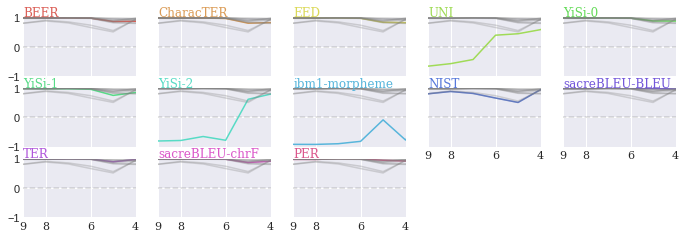

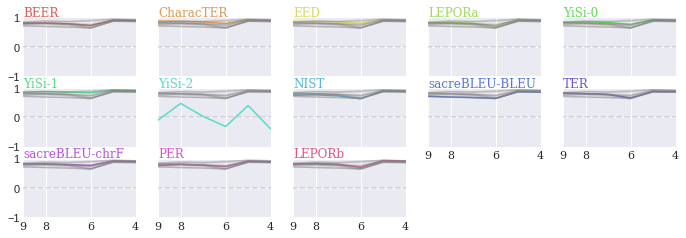

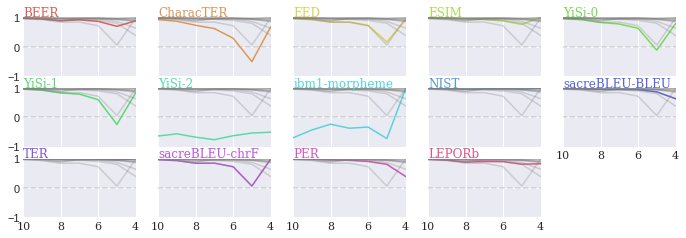

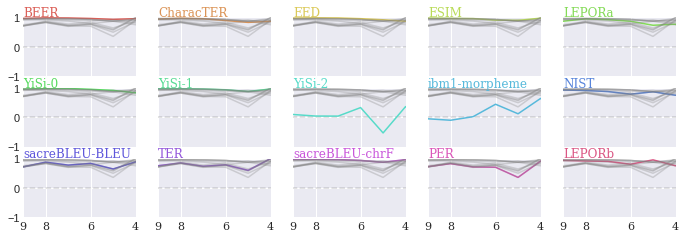

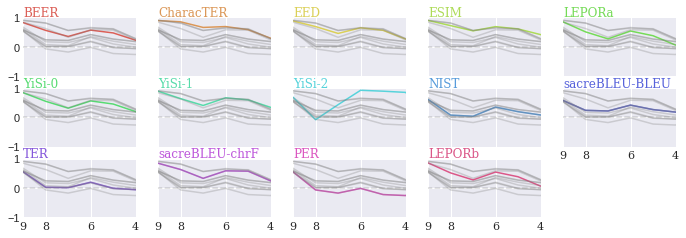

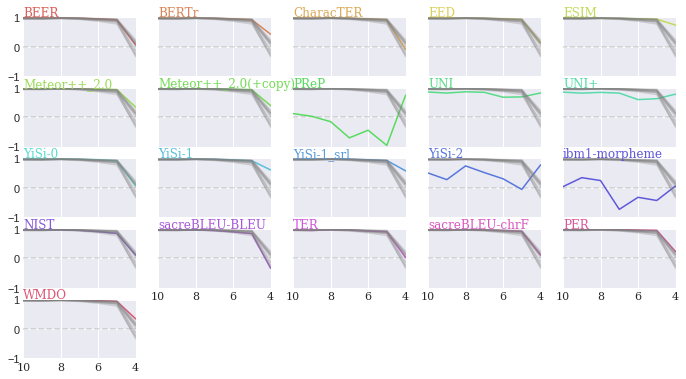

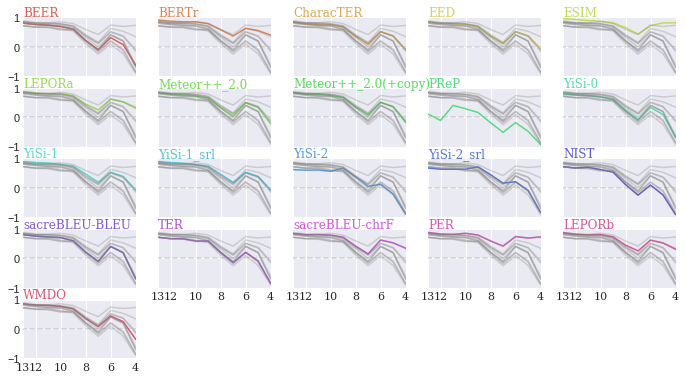

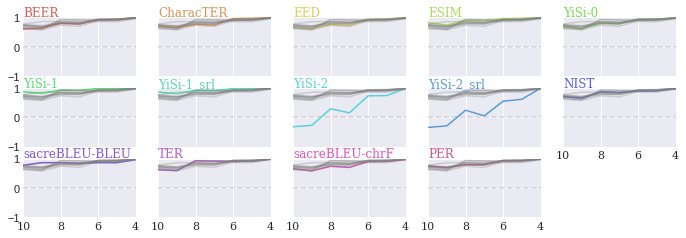

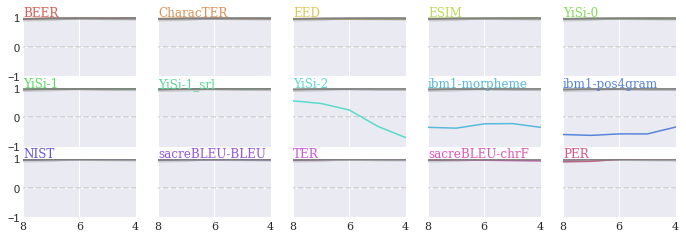

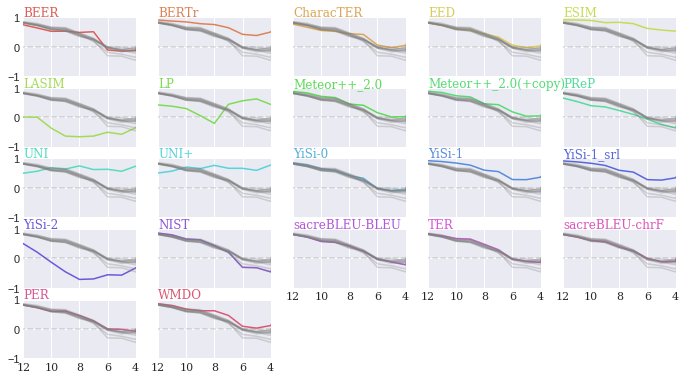

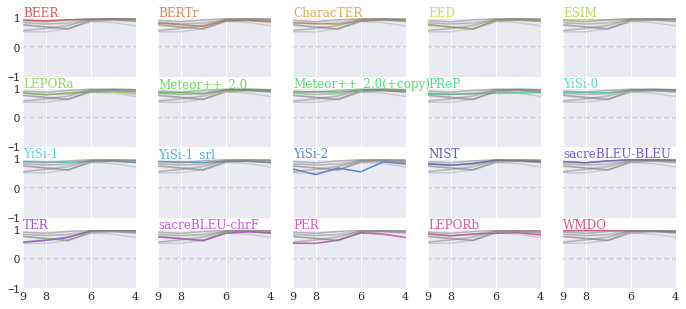

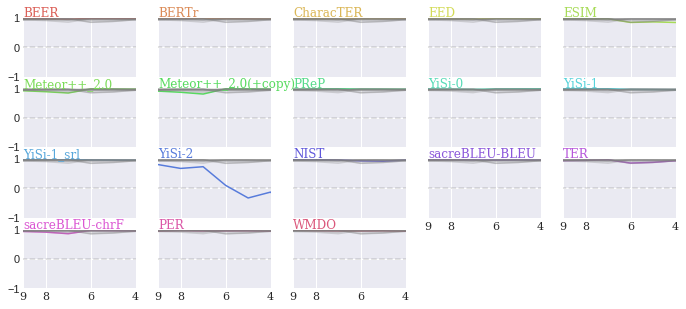

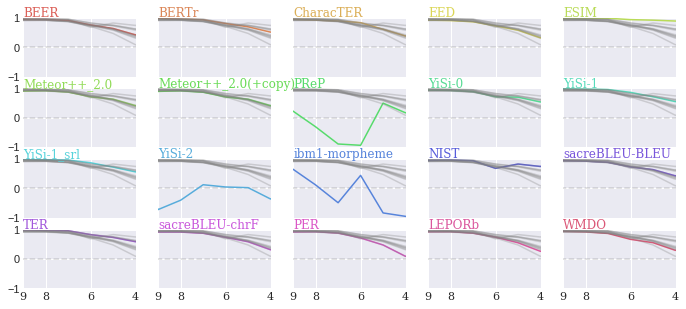

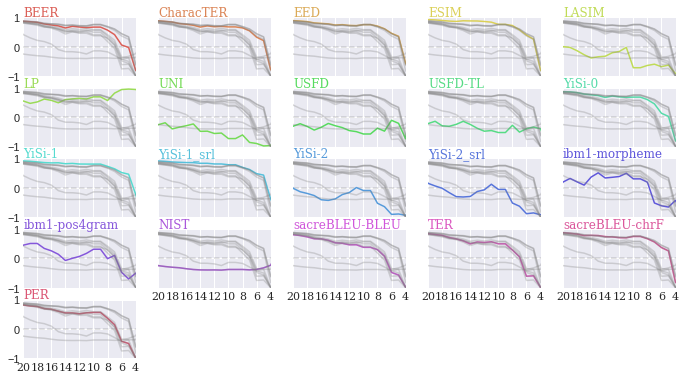

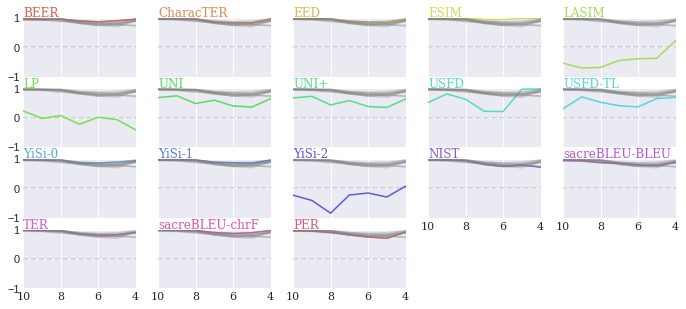

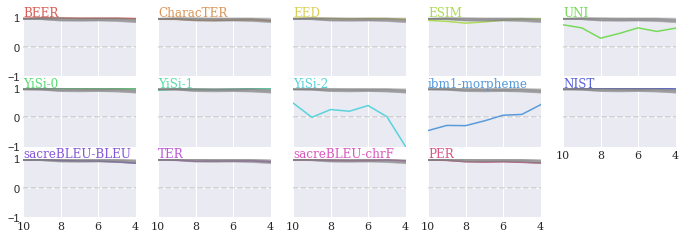

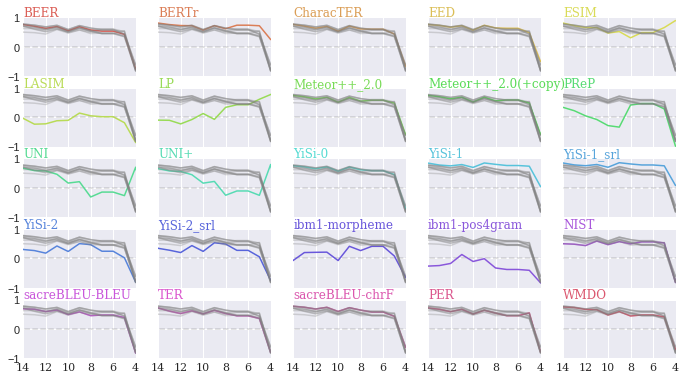

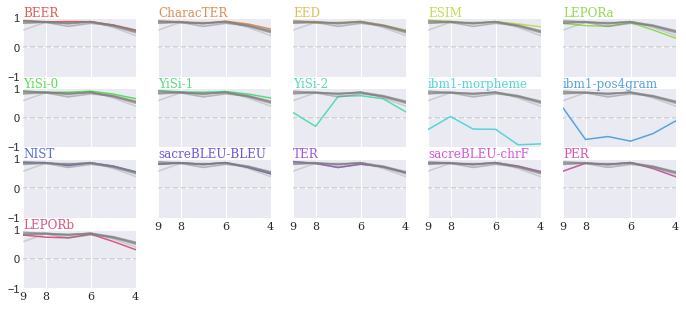

In [52]:
import warnings
warnings.filterwarnings("ignore")
# use LaTeX fonts in the plot
import matplotlib
matplotlib.rc('font', family='serif')

for lp, top_n in lp_top_n.items():
    baselines = ['BLEU', 'NIST', 'TER', 'WER', 'PER', 'CDER', 'chrF', 'chrF+', 'sacreBLEU-BLEU', 'sacreBLEU-chrF']
    draw_baselines = ['sacreBLEU-BLEU', 'NIST', 'sacreBLEU-chrF', 'PER', 'TER']
    ignores = ['DA', 'rank']
    num_participants = len(top_n.columns) + len(draw_baselines) - len(baselines) - len(ignores)

    #A4
    plt.style.use('seaborn-darkgrid')
    FIGSIZE = (11.69, 6.27)
    plt.figure(figsize=FIGSIZE)
    palette = sns.color_palette('hls', num_participants)
    
    # general title
    # plt.suptitle(lp, fontsize=15)
    # plt.gcf().text(0.5, 0.00, '# of systems (sorted ascending)', ha='center', va='center')
    # plt.gcf().text(0.00, 0.5, 'Pearson\'s $r$', ha='center', va='center', rotation='vertical')
    
    i = 0
    print(lp)
    for column in top_n.columns:
        if i > 25:
            break
        
        # plot only participants
        if (column in baselines or column in ignores) and column not in draw_baselines:
            continue
        
        i += 1
        plt.subplot(5, 5, i)
        
        
        # same limits for everybody
        plt.xlim(4, len(top_n))
        plt.ylim(-1, 1)
        plt.xticks(list(range(4, len(top_n), 2)) + [ len(top_n) ], fontfamily='serif' )      # add limit ticks
        
        plt.gca().invert_xaxis()
        plt.hlines(0, 0, 50, color='grey', alpha=0.3, linestyles='dashed')
        
        # plots
        plt.plot(top_n['rank'], top_n[column], color=palette[i-1])
        for baseline in baselines:
            plt.plot(top_n['rank'], top_n[baseline], color='grey', alpha=0.3)
        
        # Not ticks everywhere
        if i < num_participants-4:
            plt.tick_params(labelbottom='off')
        if i not in [1,6,11,16,21] :
            plt.tick_params(labelleft='off')
    
        if column == 'Meteor++_2.0(syntax)':
            column = 'Meteor++_2.0'
        elif column == 'Meteor++_2.0(syntax+copy)':
            column = 'Meteor++_2.0(+copy)'
        # Add title
        plt.title(column, loc='left', pad=1, fontfamily='serif', color=palette[i-1])
    
    # save fig
    plt.savefig('top_n/%s.pdf' % lp, bbox_inches='tight', pad_inches=0)

In [55]:
# by Ondrej's request
df.to_csv('sys-level_scores_metrics.csv')

### doc-level baselines

In [ ]:
doc_baseline_scores = pd.read_csv(gzip.open(os.path.join(WMT19_ROOT, 'baselines/mteval-inter.doc.score.gz'), 'rt'), delimiter=' ', header=None)
doc_baseline_scores.columns = ['metric', 'lp', 'testset', 'docid', 'system', 'score']

doc_baseline_scores = pd.merge(doc_baseline_scores[doc_baseline_scores.metric == 'NIST'], doc_baseline_scores[doc_baseline_scores.metric == 'BLEU'],
                              on=['lp', 'testset', 'docid', 'system'])
doc_baseline_scores = doc_baseline_scores.drop(['metric_x', 'metric_y', 'testset'], axis=1)
doc_baseline_scores.columns = ['lp', 'system', 'docid', 'NIST', 'BLEU']

In [ ]:
# no testsuites
doc_baseline_scores_nots = doc_baseline_scores[~doc_baseline_scores.docid.str.contains('testsuite')]
print(len(doc_baseline_scores_nots))

### doc-level submissions that are averages

In [ ]:
doc_submission_scores_nots = seg_all_scores[~seg_all_scores.docid.str.contains('testsuite')].groupby(['lp', 'system', 'docid']).mean()
print(len(doc_submission_scores_nots))

In [ ]:
doc_all_scores = pd.merge(doc_submission_scores_nots, doc_baseline_scores_nots, on=['lp', 'system', 'docid'], how='outer')
doc_all_scores

In [ ]:
# check if all docs have bleu scores
print(doc_all_scores[doc_all_scores.BLEU.isna()])
doc_all_scores[doc_all_scores.BLEU.isna()]['system'].unique()

In [ ]:
df.groupby(['lp']).count()['DA']